In [29]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation

In [30]:
import numpy as np

In [31]:
from collections import defaultdict, Counter
from scipy.sparse import csr_matrix

class MultiGraph:
    def __init__(self):
        self.n_nodes = 0
        self.n_rels = 0
        self.nodes = {}
        self.rels = {}
        self.node_labels = []
        self.rel_labels = []
        self.sparse_graph = {} #{relation: [row, col, data]}
        self.rel_counter = Counter()
    
    def add_connection(self, connection):
        # connection is (source, relation, target)
        src,rel,targ = connection
        #add new nodes and relations to dictionaries
        if src not in self.nodes.keys():
            self.nodes[src] = self.n_nodes
            self.node_labels.append(src)
            self.n_nodes += 1
        if targ not in self.nodes.keys():
            self.nodes[targ] = self.n_nodes
            self.node_labels.append(targ)
            self.n_nodes += 1
        if rel not in self.rels.keys():
            self.rels[rel] = self.n_rels
            self.rel_labels.append(rel)
            self.n_rels += 1
            self.sparse_graph[self.rels[rel]] = [[],[],[]] #{relation: [row, col, data]}
        #count number of relations
        self.rel_counter.update({rel: 1})
        # add new connection to graph
        self.sparse_graph[self.rels[rel]][0].append(self.nodes[src])
        self.sparse_graph[self.rels[rel]][1].append(self.nodes[targ])
        self.sparse_graph[self.rels[rel]][2].append(True)
    
    def get_adjacency_matrix(self):
        #iterleave all the columns from the individual adjacency matrices
        #it is an out-going adjacency graph
        full_matrix = [[],[],[]]
        for k in range(self.n_rels):
            full_matrix[0].extend(self.sparse_graph[k][0])
            #shift the column index to fit the added relation 
            col_shift = [i*self.n_rels+k for i in self.sparse_graph[k][1]]
            full_matrix[1].extend(col_shift)
            full_matrix[2].extend(self.sparse_graph[k][2])
        shape = (self.n_nodes,self.n_nodes*self.n_rels)
        return csr_matrix((full_matrix[2], (full_matrix[0],full_matrix[1])), shape=shape, dtype=np.bool)
    
    def get_adjacency_matrix_k(self,k):
        #it is an out-going adjacency graph of relation k
        graph_k = self.sparse_graph[self.rels[k]]
        shape = (self.n_nodes,self.n_nodes)
        return csr_matrix((graph_k[2], (graph_k[0],graph_k[1])), shape=shape, dtype=np.bool)
    
    def get_node_label(self,index):
        return self.node_labels[index]
    
    def get_relation_label(self,index):
        return self.rel_labels[index]
    
    def get_relation_counter(self):
        return self.counter

In [32]:
import csv
""" EXAMPLE
add,IS,operator
subtract,IS,operator
multiply,IS,operator
divide,IS,operator
open_closure,IS,operator
close_closure,IS,operator
"""
op_graph = MultiGraph()
with open('operator_graph.csv', 'r') as csvfile:
    graphreader = csv.reader(csvfile)
    for row in graphreader:
        #print(row)
        op_graph.add_connection(row)

In [33]:
a_graph = op_graph.get_adjacency_matrix()
print("number of nodes",op_graph.n_nodes)
print("number of relations",op_graph.n_rels)
#print("node labels",op_graph.node_labels)
print(op_graph.rel_counter)

('number of nodes', 14)
('number of relations', 5)
Counter({'IsA': 9, 'TakesNArgs': 9, 'UsedFor': 9, 'InverseOf': 6, 'DerivedFrom': 1})


In [34]:
x_train = a_graph.toarray()
print('input dims:',x_train.shape)
print(type(x_train))

('input dims:', (14, 70))
<type 'numpy.ndarray'>


In [35]:
encoding_dim = 2
input_dim = op_graph.n_nodes*op_graph.n_rels

inputs = Input(shape=(input_dim,),dtype = 'int8', sparse = True)
# Encoder Layers
encoding_1 = Dense(4 * encoding_dim, activation='relu',name="encoding_1")(inputs)
encoding_2 = Dense(2 * encoding_dim, activation='relu',name="encoding_2")(encoding_1)
the_code = Dense(encoding_dim, activation='relu',name="the_code")(encoding_2)
# Decoder Layers
decoding_1 = Dense(4 * encoding_dim, activation='relu',name="decoding_1")(the_code)
decoding_2 = Dense(2 * encoding_dim, activation='relu',name="decoding_2")(decoding_1)
reconstruction = Dense(input_dim, activation='sigmoid',name="reconstruction")(decoding_2)

ae = Model(inputs=inputs, outputs=reconstruction)
ae.compile(optimizer='adam', loss='mse')
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 70)                0         
_________________________________________________________________
encoding_1 (Dense)           (None, 8)                 568       
_________________________________________________________________
encoding_2 (Dense)           (None, 4)                 36        
_________________________________________________________________
the_code (Dense)             (None, 2)                 10        
_________________________________________________________________
decoding_1 (Dense)           (None, 8)                 24        
_________________________________________________________________
decoding_2 (Dense)           (None, 4)                 36        
_________________________________________________________________
reconstruction (Dense)       (None, 70)                350       
Total para

In [36]:
ae.fit(x_train, x_train, epochs=1000, shuffle=False)

Epoch 1/1000
14/14 [==============================] - 0s - loss: 0.2507
Epoch 2/1000
14/14 [==============================] - 0s - loss: 0.2504
Epoch 3/1000
14/14 [==============================] - 0s - loss: 0.2501
Epoch 4/1000
14/14 [==============================] - 0s - loss: 0.2498
Epoch 5/1000
14/14 [==============================] - 0s - loss: 0.2495
Epoch 6/1000
14/14 [==============================] - 0s - loss: 0.2492
Epoch 7/1000
14/14 [==============================] - 0s - loss: 0.2489
Epoch 8/1000
14/14 [==============================] - 0s - loss: 0.2486
Epoch 9/1000
14/14 [==============================] - 0s - loss: 0.2483
Epoch 10/1000
14/14 [==============================] - 0s - loss: 0.2480
Epoch 11/1000
14/14 [==============================] - 0s - loss: 0.2478
Epoch 12/1000
14/14 [==============================] - 0s - loss: 0.2475
Epoch 13/1000
14/14 [==============================] - 0s - loss: 0.2472
Epoch 14/1000
14/14 [==============================] - 0s - 

14/14 [==============================] - 0s - loss: 0.1844
Epoch 114/1000
14/14 [==============================] - 0s - loss: 0.1827
Epoch 115/1000
14/14 [==============================] - 0s - loss: 0.1810
Epoch 116/1000
14/14 [==============================] - 0s - loss: 0.1793
Epoch 117/1000
14/14 [==============================] - 0s - loss: 0.1775
Epoch 118/1000
14/14 [==============================] - 0s - loss: 0.1757
Epoch 119/1000
14/14 [==============================] - 0s - loss: 0.1738
Epoch 120/1000
14/14 [==============================] - 0s - loss: 0.1719
Epoch 121/1000
14/14 [==============================] - 0s - loss: 0.1700
Epoch 122/1000
14/14 [==============================] - 0s - loss: 0.1680
Epoch 123/1000
14/14 [==============================] - 0s - loss: 0.1660
Epoch 124/1000
14/14 [==============================] - 0s - loss: 0.1639
Epoch 125/1000
14/14 [==============================] - 0s - loss: 0.1618
Epoch 126/1000
14/14 [==============================]

14/14 [==============================] - 0s - loss: 0.0299
Epoch 224/1000
14/14 [==============================] - 0s - loss: 0.0297
Epoch 225/1000
14/14 [==============================] - 0s - loss: 0.0296
Epoch 226/1000
14/14 [==============================] - 0s - loss: 0.0294
Epoch 227/1000
14/14 [==============================] - 0s - loss: 0.0293
Epoch 228/1000
14/14 [==============================] - 0s - loss: 0.0291
Epoch 229/1000
14/14 [==============================] - 0s - loss: 0.0289
Epoch 230/1000
14/14 [==============================] - 0s - loss: 0.0288
Epoch 231/1000
14/14 [==============================] - 0s - loss: 0.0287
Epoch 232/1000
14/14 [==============================] - 0s - loss: 0.0285
Epoch 233/1000
14/14 [==============================] - 0s - loss: 0.0284
Epoch 234/1000
14/14 [==============================] - 0s - loss: 0.0283
Epoch 235/1000
14/14 [==============================] - 0s - loss: 0.0281
Epoch 236/1000
14/14 [==============================]

14/14 [==============================] - 0s - loss: 0.0225
Epoch 334/1000
14/14 [==============================] - 0s - loss: 0.0225
Epoch 335/1000
14/14 [==============================] - 0s - loss: 0.0225
Epoch 336/1000
14/14 [==============================] - 0s - loss: 0.0224
Epoch 337/1000
14/14 [==============================] - 0s - loss: 0.0224
Epoch 338/1000
14/14 [==============================] - 0s - loss: 0.0224
Epoch 339/1000
14/14 [==============================] - 0s - loss: 0.0224
Epoch 340/1000
14/14 [==============================] - 0s - loss: 0.0224
Epoch 341/1000
14/14 [==============================] - 0s - loss: 0.0224
Epoch 342/1000
14/14 [==============================] - 0s - loss: 0.0223
Epoch 343/1000
14/14 [==============================] - 0s - loss: 0.0223
Epoch 344/1000
14/14 [==============================] - 0s - loss: 0.0223
Epoch 345/1000
14/14 [==============================] - 0s - loss: 0.0223
Epoch 346/1000
14/14 [==============================]

14/14 [==============================] - 0s - loss: 0.0206
Epoch 444/1000
14/14 [==============================] - 0s - loss: 0.0205
Epoch 445/1000
14/14 [==============================] - 0s - loss: 0.0205
Epoch 446/1000
14/14 [==============================] - 0s - loss: 0.0205
Epoch 447/1000
14/14 [==============================] - 0s - loss: 0.0205
Epoch 448/1000
14/14 [==============================] - 0s - loss: 0.0204
Epoch 449/1000
14/14 [==============================] - 0s - loss: 0.0204
Epoch 450/1000
14/14 [==============================] - 0s - loss: 0.0204
Epoch 451/1000
14/14 [==============================] - 0s - loss: 0.0204
Epoch 452/1000
14/14 [==============================] - 0s - loss: 0.0203
Epoch 453/1000
14/14 [==============================] - 0s - loss: 0.0203
Epoch 454/1000
14/14 [==============================] - 0s - loss: 0.0203
Epoch 455/1000
14/14 [==============================] - 0s - loss: 0.0203
Epoch 456/1000
14/14 [==============================]

14/14 [==============================] - 0s - loss: 0.0164
Epoch 554/1000
14/14 [==============================] - 0s - loss: 0.0163
Epoch 555/1000
14/14 [==============================] - 0s - loss: 0.0163
Epoch 556/1000
14/14 [==============================] - 0s - loss: 0.0162
Epoch 557/1000
14/14 [==============================] - 0s - loss: 0.0162
Epoch 558/1000
14/14 [==============================] - 0s - loss: 0.0161
Epoch 559/1000
14/14 [==============================] - 0s - loss: 0.0161
Epoch 560/1000
14/14 [==============================] - 0s - loss: 0.0161
Epoch 561/1000
14/14 [==============================] - 0s - loss: 0.0160
Epoch 562/1000
14/14 [==============================] - 0s - loss: 0.0160
Epoch 563/1000
14/14 [==============================] - 0s - loss: 0.0160
Epoch 564/1000
14/14 [==============================] - 0s - loss: 0.0159
Epoch 565/1000
14/14 [==============================] - 0s - loss: 0.0159
Epoch 566/1000
14/14 [==============================]

14/14 [==============================] - 0s - loss: 0.0135
Epoch 664/1000
14/14 [==============================] - 0s - loss: 0.0134
Epoch 665/1000
14/14 [==============================] - 0s - loss: 0.0134
Epoch 666/1000
14/14 [==============================] - 0s - loss: 0.0134
Epoch 667/1000
14/14 [==============================] - 0s - loss: 0.0134
Epoch 668/1000
14/14 [==============================] - 0s - loss: 0.0134
Epoch 669/1000
14/14 [==============================] - 0s - loss: 0.0134
Epoch 670/1000
14/14 [==============================] - 0s - loss: 0.0133
Epoch 671/1000
14/14 [==============================] - 0s - loss: 0.0133
Epoch 672/1000
14/14 [==============================] - 0s - loss: 0.0133
Epoch 673/1000
14/14 [==============================] - 0s - loss: 0.0133
Epoch 674/1000
14/14 [==============================] - 0s - loss: 0.0133
Epoch 675/1000
14/14 [==============================] - 0s - loss: 0.0133
Epoch 676/1000
14/14 [==============================]

14/14 [==============================] - 0s - loss: 0.0121
Epoch 774/1000
14/14 [==============================] - 0s - loss: 0.0120
Epoch 775/1000
14/14 [==============================] - 0s - loss: 0.0120
Epoch 776/1000
14/14 [==============================] - 0s - loss: 0.0120
Epoch 777/1000
14/14 [==============================] - 0s - loss: 0.0120
Epoch 778/1000
14/14 [==============================] - 0s - loss: 0.0120
Epoch 779/1000
14/14 [==============================] - 0s - loss: 0.0120
Epoch 780/1000
14/14 [==============================] - 0s - loss: 0.0120
Epoch 781/1000
14/14 [==============================] - 0s - loss: 0.0120
Epoch 782/1000
14/14 [==============================] - 0s - loss: 0.0120
Epoch 783/1000
14/14 [==============================] - 0s - loss: 0.0120
Epoch 784/1000
14/14 [==============================] - 0s - loss: 0.0120
Epoch 785/1000
14/14 [==============================] - 0s - loss: 0.0119
Epoch 786/1000
14/14 [==============================]

14/14 [==============================] - 0s - loss: 0.0112
Epoch 884/1000
14/14 [==============================] - 0s - loss: 0.0111
Epoch 885/1000
14/14 [==============================] - 0s - loss: 0.0111
Epoch 886/1000
14/14 [==============================] - 0s - loss: 0.0111
Epoch 887/1000
14/14 [==============================] - 0s - loss: 0.0111
Epoch 888/1000
14/14 [==============================] - 0s - loss: 0.0111
Epoch 889/1000
14/14 [==============================] - 0s - loss: 0.0111
Epoch 890/1000
14/14 [==============================] - 0s - loss: 0.0111
Epoch 891/1000
14/14 [==============================] - 0s - loss: 0.0111
Epoch 892/1000
14/14 [==============================] - 0s - loss: 0.0111
Epoch 893/1000
14/14 [==============================] - 0s - loss: 0.0111
Epoch 894/1000
14/14 [==============================] - 0s - loss: 0.0111
Epoch 895/1000
14/14 [==============================] - 0s - loss: 0.0111
Epoch 896/1000
14/14 [==============================]

14/14 [==============================] - 0s - loss: 0.0104
Epoch 994/1000
14/14 [==============================] - 0s - loss: 0.0104
Epoch 995/1000
14/14 [==============================] - 0s - loss: 0.0104
Epoch 996/1000
14/14 [==============================] - 0s - loss: 0.0104
Epoch 997/1000
14/14 [==============================] - 0s - loss: 0.0103
Epoch 998/1000
14/14 [==============================] - 0s - loss: 0.0103
Epoch 999/1000
14/14 [==============================] - 0s - loss: 0.0103
Epoch 1000/1000
14/14 [==============================] - 0s - loss: 0.0103


In [37]:
#coding_model = Model(inputs=ae.inputs, outputs=ae.get_layer("the_code").output)
coding_model = Model(inputs=inputs, outputs=the_code)
embedding = coding_model.predict(x_train)

In [38]:
for i in range(len(embedding)):
    print str(op_graph.get_node_label(i))+' : '+str(list(embedding[i]))

add : [5.689643, 7.937987]
operator : [2.0262163, 0.9244902]
subtract : [6.26791, 5.0622416]
multiply : [5.9367642, 8.484679]
divide : [6.7890067, 8.098059]
if : [5.9586244, 0.07277948]
and : [6.131841, 3.3549745]
or : [6.131841, 3.3549745]
not : [6.9685373, 0.0]
identity : [7.1519775, 0.0]
2 : [2.0262163, 0.9244902]
1 : [2.0262163, 0.9244902]
arithmatic : [2.0262163, 0.9244902]
logic : [2.0262163, 0.9244902]


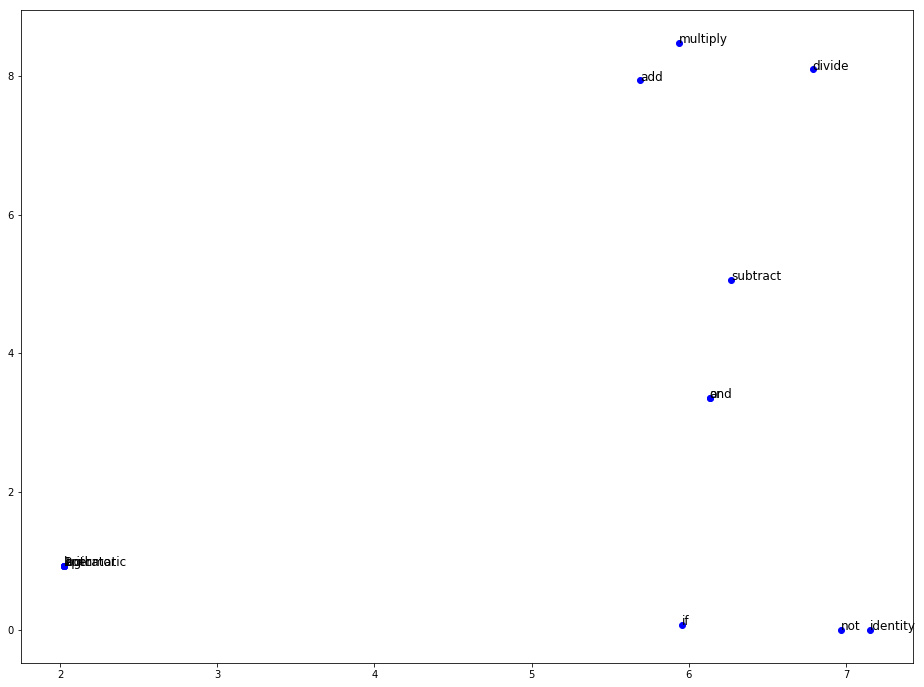

In [39]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))
#ax = fig.add_subplot(111, projection='2d')
ax = fig.add_subplot(111)
for i in range(len(embedding)):
    ax.scatter(embedding[i,0],embedding[i,1],color='b') 
    ax.text(embedding[i,0],embedding[i,1],  '%s' % (op_graph.get_node_label(i)), size=12, zorder=1, color='k') 